In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.spatial.distance import directed_hausdorff
from scipy.ndimage import generic_filter

## LÓGICA DE PROCESAMIENTO 

In [44]:
def preprocess_image(img):
    """Prepara la imagen: Gris -> Binaria -> Recorte -> Redimensión -> Esqueleto."""
    # 1. Escala de grises e Inversión Binaria
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    
    # 2. Recorte 
    coords = cv2.findNonZero(binary)
    if coords is None: return np.zeros((200, 200), dtype=np.uint8)
    x, y, w, h = cv2.boundingRect(coords)
    crop = binary[y:y+h, x:x+w]
    
    # 3. Normalización
    resized = cv2.resize(crop, (200, 200), interpolation=cv2.INTER_AREA)
    
    # 4. Esqueletización 
    skel = skeletonize(resized > 0).astype(np.uint8)
    return skel

## calculo de las metricas establecidas

In [45]:
def calculate_metrics(skel_p, skel_a):
    """Calcula similitud y distancia. Retorna solo datos numéricos."""
    # Intersección sobre Unión
    intersection = np.logical_and(skel_p, skel_a).sum()
    union = np.logical_or(skel_p, skel_a).sum()
    iou = (intersection / union) * 100 if union != 0 else 0
    
    # Distancia de Hausdorff 
    pts_p = np.argwhere(skel_p > 0)
    pts_a = np.argwhere(skel_a > 0)
    if len(pts_p) == 0 or len(pts_a) == 0: return iou, 999
    
    d1 = directed_hausdorff(pts_p, pts_a)[0]
    d2 = directed_hausdorff(pts_a, pts_p)[0]
    haus_dist = max(d1, d2)
    
    # Score simple 
    score = max(0, 100 - (haus_dist * 1.5)) 
    return round(iou, 2), round(haus_dist, 2), round(score, 2)

## VISUALIZACIÓN 

In [46]:
def create_test_images():
    """Genera imágenes de prueba"""
    p = np.full((300, 300), 255, dtype=np.uint8)
    cv2.circle(p, (150, 150), 80, 0, 2)
    a = np.full((300, 300), 255, dtype=np.uint8)
    cv2.ellipse(a, (155, 145), (85, 80), 0, 0, 360, 0, 6) 
    return p, a

def show_debug_plots(img_p, img_a, skel_p, skel_a, metrics):
    """Muestra la comparación visual"""
    iou, haus, score = metrics
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_p, cmap='gray'); ax[0].set_title("Patrón Original")
    ax[1].imshow(img_a, cmap='gray'); ax[1].set_title("Alumno Original")
    
    # Overlay: Patrón Verde, Alumno Rojo
    overlay = np.zeros((200, 200, 3), dtype=np.uint8)
    overlay[skel_p > 0] = [0, 255, 0] # Verde
    overlay[skel_a > 0] = [255, 0, 0] # Rojo
    ax[2].imshow(overlay); ax[2].set_title(f"Score: {score}")
    plt.tight_layout()
    plt.show()

## FLUJO PRINCIPAL 

DATOS PARA DB -> IoU: 0.0%, Hausdorff: 3.61, Score: 94.59


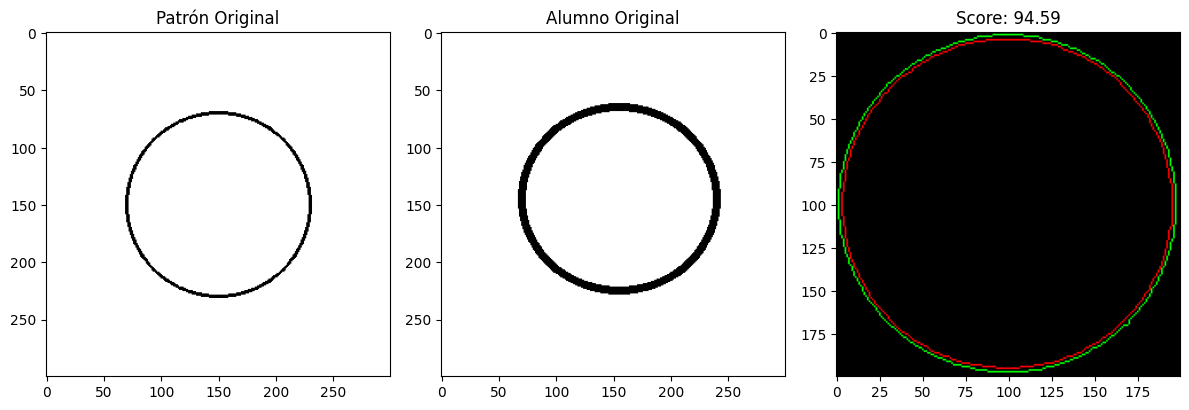

In [47]:
# FLUJO PRINCIPAL 
if __name__ == "__main__":
    # Simular entrada de imágenes
    img_p, img_a = create_test_images()
    
    # Procesamiento local 
    s_p = preprocess_image(img_p)
    s_a = preprocess_image(img_a)
    
    # Obtención de métricas 
    iou, haus, score = calculate_metrics(s_p, s_a)
    
    print(f"DATOS PARA DB -> IoU: {iou}%, Hausdorff: {haus}, Score: {score}")
    
    # Visualización 
    show_debug_plots(img_p, img_a, s_p, s_a, (iou, haus, score))

#### Qué pasa con la luz y la rotación?:
- Luz: Si la luz es mala, el threshold simple fallará. Necesitaremos implementar Umbral Adaptativo.
- Rotación: si el niño gira el papel, la métrica fallará porque el esqueleto estará rotado. Habría que investigar Momentos de Hu o una alineación por PCA antes de comparar.

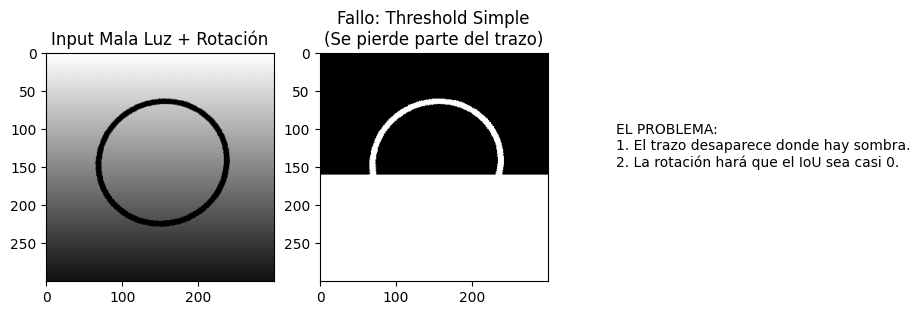

In [48]:
def simulate_bad_conditions(img):
    # 1. Simular Rotación 
    rows, cols = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 20, 1)
    rotated = cv2.warpAffine(img, M, (cols, rows), borderValue=255)
    
    # 2. Simular Mala Luz 
    dist_map = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(rows):
        dist_map[i, :] = i * 0.8 
    dirty = cv2.subtract(rotated, dist_map)
    return dirty

# --- PRUEBA DE FALLO ---
img_p, img_a = create_test_images() 
img_a_bad = simulate_bad_conditions(img_a)

# Intentar procesar con el método anterior 
_, binary_fail = cv2.threshold(img_a_bad, 127, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10, 4))
plt.subplot(131); plt.imshow(img_a_bad, cmap='gray'); plt.title("Input Mala Luz + Rotación")
plt.subplot(132); plt.imshow(binary_fail, cmap='gray'); plt.title("Fallo: Threshold Simple\n(Se pierde parte del trazo)")
plt.subplot(133); plt.text(0.1, 0.5, "EL PROBLEMA:\n1. El trazo desaparece donde hay sombra.\n2. La rotación hará que el IoU sea casi 0.", fontsize=10)
plt.axis('off'); plt.show()

## Implementación Robustecida (Umbral Adaptativo y Alineación)

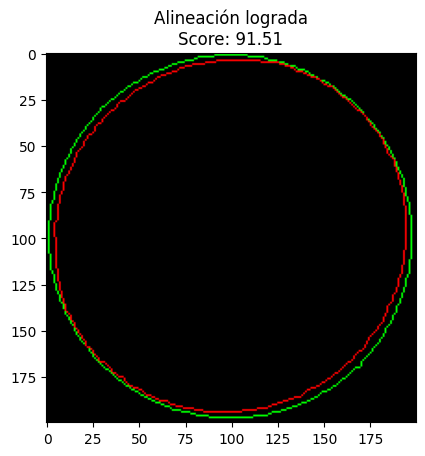

In [49]:
def preprocess_robust(img):
    # 1. Escala de grises
    if len(img.shape) == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. UMBRAL ADAPTATIVO 
    binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    
    # 3. CORRECCIÓN DE ROTACIÓN 
    coords = cv2.findNonZero(binary)
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45: angle = -(90 + angle)
    else: angle = -angle
    
    (h, w) = binary.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(binary, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT)
    
    # 4. Recorte y Redimensión 
    coords_new = cv2.findNonZero(rotated)
    x, y, w_c, h_c = cv2.boundingRect(coords_new)
    crop = rotated[y:y+h_c, x:x+w_c]
    resized = cv2.resize(crop, (200, 200), interpolation=cv2.INTER_AREA)
    
    # 5. Esqueleto
    skel = skeletonize(resized > 0).astype(np.uint8)
    return skel

# --- PRUEBA DE SOLUCIÓN ---
skel_p = preprocess_robust(img_p)
skel_a_fixed = preprocess_robust(img_a_bad)

iou, haus, score = calculate_metrics(skel_p, skel_a_fixed)

# Visualización comparativa
overlay = np.zeros((200, 200, 3), dtype=np.uint8)
overlay[skel_p > 0] = [0, 255, 0]
overlay[skel_a_fixed > 0] = [255, 0, 0]
plt.imshow(overlay); plt.title(f"Alineación lograda\nScore: {score}"); plt.show()

### Metricas a considerar: 
Se podria agregar 
1. **Características Topológicas:**
    Analizar las propiedades geométricas que no cambian con la deformación, como el número de "agujeros" o bucles.
        
    - **Métricas:**
        
        - **Conteo de Bucles:** ¿La 'o' y la 'a' tienen un bucle cerrado? ¿La 'B' tiene dos?.
            
        - **Conteo de Puntos Finales y Uniones:** Un esqueleto de la letra 'T' tiene 3 puntos finales. Una 'X' tiene 4 puntos finales y un punto de unión. Comparar esto con la plantilla puede detectar trazos incompletos o extra.
            
2. **Dynamic Time Warping (DTW) sobre la Secuencia de Puntos:**
    
    Puede determinar si el usuario dibujó la letra en el orden y dirección correctos. Por ejemplo, si dibujó una 'o' en el sentido de las agujas del reloj en lugar de en contra. Te da una medida de la similitud de la trayectoria, no solo de la imagen final

In [50]:
def get_topology_metrics(skel):
    """Analiza la estructura del trazo."""
    # 1. Conteo de Bucles usando contornos
    padded = cv2.copyMakeBorder(skel, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
    contours, hierarchy = cv2.findContours(padded, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # Si hay jerarquía, los 'holes' son contornos hijos
    loops = 0
    if hierarchy is not None:
        for h in hierarchy[0]:
            if h[3] != -1: loops += 1 
            
    # 2. Conteo de Puntos Finales y Uniones 
    def count_neighbors(P):
        if P[4] == 0: return 0
        return np.sum(P) - 1

    neighbor_map = generic_filter(skel, count_neighbors, size=(3,3))
    endpoints = np.sum(neighbor_map == 1) 
    junctions = np.sum(neighbor_map >= 3) 
    
    return loops, endpoints, junctions

# Ejemplo de uso:
loops, ends, juncs = get_topology_metrics(skel_a_fixed)
print(f"Topología del Alumno: Bucles: {loops}, Puntas: {ends}, Uniones: {juncs}")


Topología del Alumno: Bucles: 1, Puntas: 0, Uniones: 0


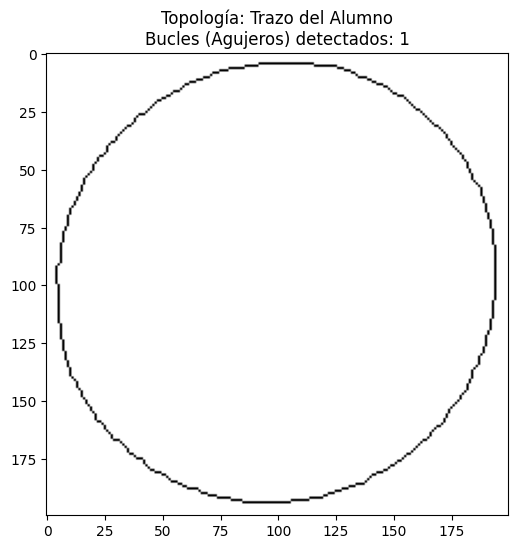

In [51]:
def plot_topology_debug(skel, title="Análisis Topológico"):
    # 1. Re-calculamos el neighbor_map para los puntos (Puntas y Uniones)
    def count_neighbors(P):
        if P[4] == 0: return 0
        return np.sum(P) - 1

    neighbor_map = generic_filter(skel, count_neighbors, size=(3,3))
    ends_coords = np.argwhere(neighbor_map == 1)
    juncs_coords = np.argwhere(neighbor_map >= 3)
    
    # 2. Usar jerarquía para contar solo agujeros reales
    padded = cv2.copyMakeBorder(skel, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=0)
    contours, hierarchy = cv2.findContours(padded, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    loops = 0
    if hierarchy is not None:
        for h in hierarchy[0]:
            if h[3] != -1:
                loops += 1

    # 3. Graficar
    plt.figure(figsize=(6, 6))
    plt.imshow(skel, cmap='gray_r') 
    if len(ends_coords) > 0:
        plt.scatter(ends_coords[:, 1], ends_coords[:, 0], c='red', s=80, 
                    label=f'Puntas ({len(ends_coords)})', edgecolors='white')
    if len(juncs_coords) > 0:
        plt.scatter(juncs_coords[:, 1], juncs_coords[:, 0], c='blue', s=80, 
                    label=f'Uniones ({len(juncs_coords)})', marker='x')
        
    plt.title(f"{title}\nBucles (Agujeros) detectados: {loops}")
    if len(ends_coords) > 0 or len(juncs_coords) > 0:
        plt.legend()
    
    plt.axis('on') 
    plt.show()

# Prueba la función con tu esqueleto actual:
plot_topology_debug(skel_a_fixed, "Topología: Trazo del Alumno")

In [52]:
def get_sequence_from_skel(skel):
    """Convierte el esqueleto en una lista de puntos (x,y) ordenados."""
    points = np.argwhere(skel > 0)
    # Ordenamos por ángulo respecto al centro para simular un trazo circular
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:,0] - center[0], points[:,1] - center[1])
    return points[np.argsort(angles)]

# Concepto de DTW
from scipy.spatial.distance import cdist

def simple_dtw_score(seq_p, seq_a):
    """Versión simplificada: Distancia promedio mínima entre secuencias."""
    distances = cdist(seq_p, seq_a, 'euclidean')
    # Promedio de las distancias mínimas 
    return np.mean(np.min(distances, axis=1))

seq_p = get_sequence_from_skel(skel_p)
seq_a = get_sequence_from_skel(skel_a_fixed)
dtw_dist = simple_dtw_score(seq_p, seq_a)
print(f"Diferencia de trayectoria (DTW-like): {dtw_dist:.2f}")

Diferencia de trayectoria (DTW-like): 2.77


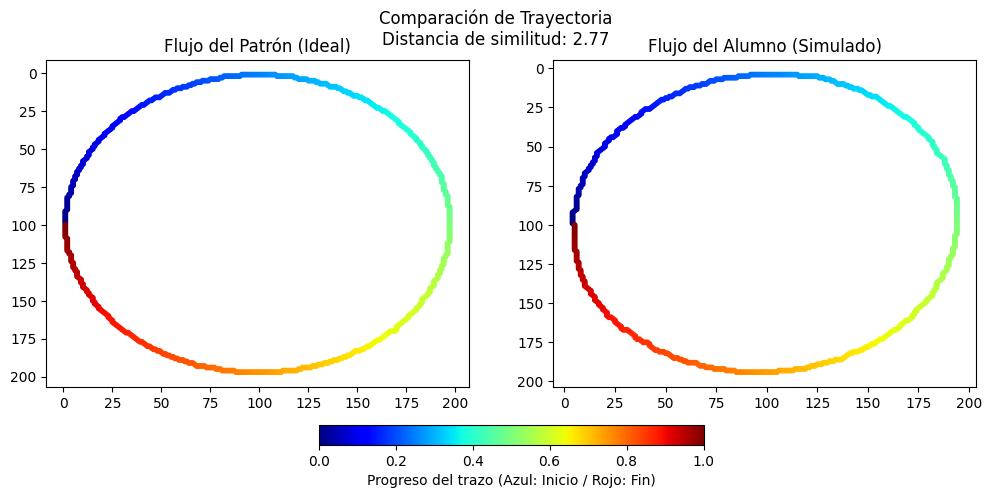

In [53]:
def plot_sequence_flow(seq_p, seq_a):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Función interna para graficar el gradiente
    def draw_flow(ax_obj, sequence, title):
        # Creamos un color por cada punto basado en su posición en la secuencia
        colors = np.linspace(0, 1, len(sequence))
        sc = ax_obj.scatter(sequence[:, 1], sequence[:, 0], c=colors, cmap='jet', s=10)
        ax_obj.set_title(title)
        ax_obj.invert_yaxis() # Para que coincida con coordenadas de imagen
        return sc

    sc_p = draw_flow(ax[0], seq_p, "Flujo del Patrón (Ideal)")
    sc_a = draw_flow(ax[1], seq_a, "Flujo del Alumno (Simulado)")
    
    # Añadir barra de color para indicar Inicio -> Fin
    cbar = fig.colorbar(sc_p, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
    cbar.set_label('Progreso del trazo (Azul: Inicio / Rojo: Fin)')
    
    plt.suptitle(f"Comparación de Trayectoria\nDistancia de similitud: {simple_dtw_score(seq_p, seq_a):.2f}")
    plt.show()

# Ejecución
plot_sequence_flow(seq_p, seq_a)